In [1]:
#mask
import json
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import keras
from keras.preprocessing import image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
import xml.etree.ElementTree as ET
from tensorflow.keras.callbacks import TensorBoard
import time

In [2]:
import tensorflow as tf

gpu_available = tf.config.list_physical_devices('GPU')
gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))
print(gpu_available)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-10-06 22:02:29.218073: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-06 22:02:29.218696: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-06 22:02:29.300192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 22:02:29.300933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-10-06 22:02:29.300996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-1

True


2022-10-06 22:02:29.316971: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-06 22:02:29.317373: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-06 22:02:29.490318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 22:02:29.490995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-10

In [2]:
model_name = "resized_500.h5"

In [4]:
CATEGORIES = ["covid", "normal"]
DATADIR = "/home/lungprojects/split_dataset/scaled_resized/train"

NAME = "Covid-"+model_name+"-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

2022-10-06 22:03:12.049976: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-10-06 22:03:12.049993: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-10-06 22:03:12.050011: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 4 GPUs
2022-10-06 22:03:12.050508: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2022-10-06 22:03:12.150872: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2022-10-06 22:03:12.152453: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


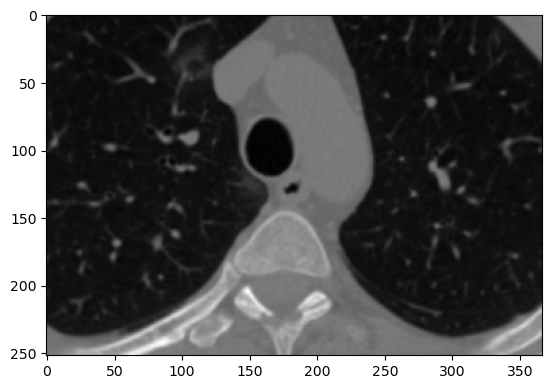

In [5]:
for categoty in CATEGORIES:
    path = os.path.join(DATADIR, categoty)  # path to Covid or Nprmal
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        break
    break

In [6]:
# Data Augmentation

IMAGE_SIZE    = (244, 244)

BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 500
LEARNING_RATE =0.0005 

train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip= True ,
    validation_split = 0.2)

In [7]:
print("Training samples:")
train_batches = train_datagen.flow_from_directory(DATADIR,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="binary")

print("\n Validation samples: ")
                                                  

valid_batches = train_datagen.flow_from_directory(DATADIR,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="binary" )





Training samples:
Found 8988 images belonging to 2 classes.

 Validation samples: 
Found 2245 images belonging to 2 classes.


In [8]:
# Output classes
train_batches.class_indices

{'covid': 0, 'normal': 1}

In [10]:

df = pd.DataFrame()
df["labels"] = list(train_batches.classes)

In [ ]:
df["labels"].value_counts()

In [10]:
len(train_batches.classes)

8988

##  Distribution of classes

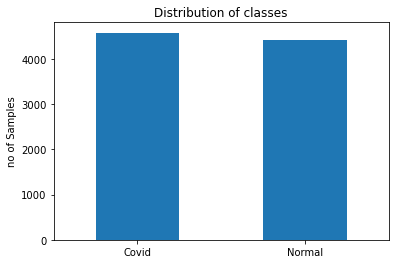

In [11]:
df["labels"].value_counts().plot(kind='bar')
plt.xticks([0,1], ["Covid", "Normal"], rotation='horizontal')
plt.ylabel('no of Samples')
plt.title('Distribution of classes')
plt.show()

In [11]:
# Model Structure
model = Sequential()

model.add(Conv2D( 32, kernel_size=(3,3),activation='relu',input_shape=(244, 244,3)))

model.add(Conv2D( 128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D( 64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D( 64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
#remove dropout - 0.2
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss = keras.losses.binary_crossentropy, optimizer = 'adam', metrics = ['accuracy'])

2022-10-06 22:05:22.726454: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-06 22:05:22.726607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 22:05:22.727304: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-10-06 22:05:22.727380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 22:05:22.728045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:04:00.0 name: 

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 242, 242, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 240, 128)     36992     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 120, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 120, 120, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 118, 118, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 59, 59, 64)        0

In [ ]:
model.save(model_name)

In [14]:

result = model.fit_generator(train_batches,
                        steps_per_epoch = len(train_batches),
                        validation_data = valid_batches,
                        validation_steps = len(valid_batches),
                        epochs= NUM_EPOCHS,
                        callbacks=[tensorboard])

model.save("/home/lungprojects/models"+model_name)


/home/lungprojects/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-10-06 22:06:04.971397: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-06 22:06:04.988233: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


Epoch 1/500


2022-10-06 22:06:05.356437: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-06 22:06:05.611094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


  1/281 [..............................] - ETA: 22:25 - loss: 0.6942 - accuracy: 0.5312

2022-10-06 22:06:09.815637: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-10-06 22:06:09.815655: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-10-06 22:06:09.816988: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


  2/281 [..............................] - ETA: 1:53 - loss: 0.7967 - accuracy: 0.4688 

2022-10-06 22:06:10.214179: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-10-06 22:06:10.215066: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-10-06 22:06:10.223024: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-10-06 22:06:10.226033: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/Covid-resized_500.h5-1665108192/train/plugins/profile/2022_10_06_22_06_10
2022-10-06 22:06:10.226381: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/Covid-resized_500.h5-1665108192/train/plugins/profile/2022_10_06_22_06_10/thiago-desktop.trace.json.gz
2022-10-06 22:06:10.232785: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/Covid-resized_500.h5-1665108192/train/plugins/profile/2022_10_06_22_0

281/281 [==============================] - 136s 468ms/step - loss: 0.6115 - accuracy: 0.6750 - val_loss: 0.4556 - val_accuracy: 0.8218
Epoch 2/500
281/281 [==============================] - 128s 454ms/step - loss: 0.4274 - accuracy: 0.8253 - val_loss: 0.4004 - val_accuracy: 0.8062
Epoch 3/500
281/281 [==============================] - 128s 455ms/step - loss: 0.3819 - accuracy: 0.8431 - val_loss: 0.4029 - val_accuracy: 0.8325
Epoch 4/500
281/281 [==============================] - 128s 454ms/step - loss: 0.3722 - accuracy: 0.8508 - val_loss: 0.3924 - val_accuracy: 0.8405
Epoch 5/500
281/281 [==============================] - 128s 454ms/step - loss: 0.3595 - accuracy: 0.8548 - val_loss: 0.3578 - val_accuracy: 0.8557
Epoch 6/500
281/281 [==============================] - 128s 453ms/step - loss: 0.3392 - accuracy: 0.8647 - val_loss: 0.3493 - val_accuracy: 0.8597
Epoch 7/500
281/281 [==============================] - 127s 453ms/step - loss: 0.3367 - accuracy: 0.8634 - val_loss: 0.3653 - val_

## Evaluating the model on Test dataset

In [ ]:
# Load the model
from keras.models import load_model
model = load_model(model_name)

In [15]:
test_dir = "/home/lungprojects/split_dataset/scaled_resized/test"


test_datagen = image.ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=False,
        seed=42,      
        class_mode="binary")

Found 2809 images belonging to 2 classes.


In [16]:
x = model.evaluate(eval_generator,
                       steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                       use_multiprocessing = False,
                       verbose = 1,
                       workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

88/88 [==============================] - 1s 6ms/step - loss: 0.3437 - accuracy: 0.8750
Test loss: 0.3436829149723053
Test accuracy: 0.875


In [17]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
pred = model.predict(eval_generator,len(eval_generator.classes),verbose=1)
print("Predictions finished")

2809/2809 [==============================] - 13s 5ms/step
Predictions finished


In [18]:
y_test = eval_generator.classes
y_pred = (pred > 0.5).astype("int32")

In [19]:
from sklearn.metrics import classification_report 
print(classification_report(eval_generator.classes, y_pred, target_names=["covid", "Normal"]))

              precision    recall  f1-score   support

       covid       0.99      0.93      0.96      1430
      Normal       0.93      0.99      0.96      1379

    accuracy                           0.96      2809
   macro avg       0.96      0.96      0.96      2809
weighted avg       0.96      0.96      0.96      2809



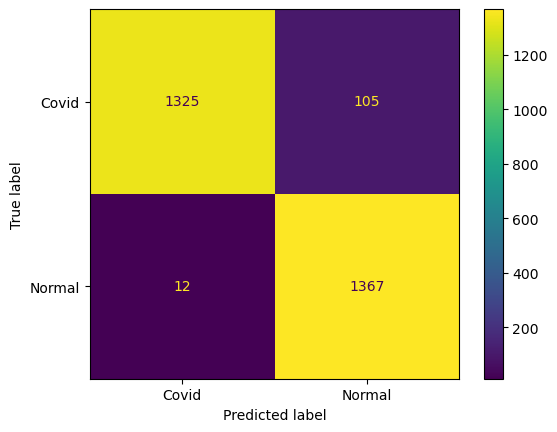

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(eval_generator.classes, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal"])
disp.plot()
plt.show()
